In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

In [2]:
cities = pd.read_csv('DS/cities.csv')
districts = pd.read_csv('DS/districts.csv')
train = pd.read_csv('DS/train.csv')
# test = pd.read_csv('DS/test.csv')

In [4]:
cities = cities.rename(columns={'id': 'city_id'})
districts = districts.rename(columns={'id': 'district_id'})

In [5]:
intermediate = pd.merge(train, districts, left_on='district_id', right_on='district_id', how='left')
train = pd.merge(intermediate, cities, left_on='city_id', right_on='city_id', suffixes=['_district', '_city'])

# intermediate = pd.merge(test, districts, left_on='district_id', right_on='district_id', how='left')
# test = pd.merge(intermediate, cities, left_on='city_id', right_on='city_id', suffixes=['_district', '_city'])

In [6]:
train = train[train['name_pl_city'] == 'Warszawa'][(train['name_pl_district'] == 'Mokotów') | (train['name_pl_district'] == 'Śródmieście') | (train['name_pl_district'] == 'Ochota') | (train['name_pl_district'] == 'Wola')]
train = train.reset_index().drop(columns=['index'])

/tmp/ipykernel_25498/1836881820.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[train['name_pl_city'] == 'Warszawa'][(train['name_pl_district'] == 'Mokotów') | (train['name_pl_district'] == 'Śródmieście') | (train['name_pl_district'] == 'Ochota') | (train['name_pl_district'] == 'Wola')]


In [7]:
def parse_params(params):
    result = {}
    params = params.split('<br>')

    for p in params:
        kv = p.split('<=>')
        if len(kv) >= 2:
            key, value = p.split('<=>')
            result[key] = value

    return result

In [8]:
train = train.join(pd.DataFrame([parse_params(train.at[idx, 'params']) for idx in tqdm.tqdm(range(len(train)))]))

100%|██████████| 47829/47829 [00:00<00:00, 60568.14it/s]


In [9]:
def preprocess_columns(types_columns):
    gather = []
    sz = len(types_columns[0][0])
    for row_idx in range(sz):
        result = {}
        for column, cname in types_columns:
            if type(column[row_idx]) == str and column[row_idx] != '' and column[row_idx] != '0':
                values = column[row_idx].split('<->')
                if len(values) > 0:
                    for v in values:
                        result[f"{cname}_{v}"] = 1
        gather.append(result)
    return gather

In [10]:
train = train.join(pd.DataFrame(preprocess_columns([(train[col], col) for col in train.columns if col.endswith('_types')])))

In [131]:
import html2text
import re
from googletrans import Translator
translator = Translator()

delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())

def strip(s):
    return ''.join(ch for ch in s if ch != '*')

print((strip(html2text.html2text(train.at[0, 'description']))))

Oferta dotyczy świeżo wykończonego, 3 pokojowego mieszkania w prestiżowej
dzielnicy Mokotowa. Mieszkanie znajduje się na 1 piętrze budynku, na akcie
wpisane 73m2 powierzchni + 10 m2 balkon. Faktycznie jest o ok. 2 m większe.

Okna mieszkania ani taras nie wychodzą bezpośrednio na ulicę.

Obecnie jest podzielone na duży przedpokój, 2 łazienki, 2 pokoje + salon z
dużym aneksem kuchennym, jednak istnieje możliwość wstawienia ścianki
działowej aby wyodrębnić 3 pokoje. Ściana została wyburzona w trakcie
wykańczania. Mieszkanie jest ciche i słoneczne, położone na zamkniętym osiedlu
z ochroną, windą i garażem podziemnym.

Wnętrze urządzone przytulnie w nowoczesnej stylistyce. Dzięki dużym,
drewnianym oknom we wszystkich pomieszczeniach jest jasno. Od strony salonu
roztacza się z nich widok na teren zielony, a od strony sypialni i drugiego
pokoju na patio. Kuchnia robiona w całości na zamówienie, w pełni wyposażona w
sprzęt AGD (piekarnik, płyta grzewcza, okap, lodówka/zamrażarka, zmywarka,
mi

In [132]:
train.at[0, 'description']

'<p>Oferta dotyczy świeżo wykończonego, 3 pokojowego mieszkania w prestiżowej dzielnicy Mokotowa. Mieszkanie znajduje się na 1 piętrze budynku, na akcie wpisane 73m2 powierzchni + 10 m2 balkon. Faktycznie jest o ok. 2 m większe.</p>\n<p>Okna mieszkania ani taras nie wychodzą bezpośrednio na ulicę.</p>\n<p>Obecnie jest podzielone na duży przedpokój, 2 łazienki, 2 pokoje + salon z dużym aneksem kuchennym, jednak istnieje możliwość wstawienia ścianki działowej aby wyodrębnić 3 pokoje. Ściana została wyburzona w trakcie wykańczania. Mieszkanie jest ciche i słoneczne, położone na zamkniętym osiedlu z ochroną, windą i garażem podziemnym.</p>\n<p>Wnętrze urządzone przytulnie w nowoczesnej stylistyce. Dzięki dużym, drewnianym oknom we wszystkich pomieszczeniach jest jasno. Od strony salonu roztacza się z nich widok na teren zielony, a od strony sypialni i drugiego pokoju na patio. Kuchnia robiona w całości na zamówienie, w pełni wyposażona w sprzęt AGD (piekarnik, płyta grzewcza, okap, lodówka

In [12]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased");
model = AutoModel.from_pretrained("allegro/herbert-base-cased").cuda()

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
list(train['construction_status'])

['ready_to_use',
 'ready_to_use',
 '',
 'to_completion',
 'ready_to_use',
 '',
 '',
 'ready_to_use',
 '',
 '',
 'ready_to_use',
 'to_completion',
 '',
 'ready_to_use',
 'to_completion',
 '',
 'to_completion',
 'ready_to_use',
 '',
 'to_completion',
 'ready_to_use',
 'to_completion',
 'to_completion',
 '',
 'to_completion',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 '',
 '',
 'to_completion',
 'to_completion',
 'ready_to_use',
 'ready_to_use',
 'to_completion',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 'to_completion',
 'ready_to_use',
 '',
 '',
 '',
 'to_completion',
 '',
 'ready_to_use',
 'to_completion',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 '',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 '',
 'ready_to_use',
 'ready_to_use',
 '',
 'to_completion',
 '',
 'ready_to_use',
 'ready_to_use',
 '',
 'ready_to_use',
 'ready_to_use',
 'ready_to_use',
 '',
 '',
 'ready_to_use',
 '',
 '',
 'ready_to_use'

In [16]:
descriptions = []
for desc in tqdm.tqdm(train['description']):
    if type(desc) != str:
        continue

    d = tokenizer.batch_encode_plus([desc],
        padding='longest',
        add_special_tokens=True,
        return_tensors='pt'
    )
    for k in d:
        d[k] = d[k][:, :512].cuda()

    output = model(**d)
    descriptions.append(output.pooler_output.detach().cpu())

100%|██████████| 47829/47829 [20:31<00:00, 38.85it/s]


In [23]:
import numpy as np
embeddings = np.array([d.numpy() for d in descriptions])[:, 0, :]

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor

cross_val_score(DummyRegressor(), embeddings, train['price'], cv=5, scoring='neg_mean_squared_error').mean()

-507700187082.0915

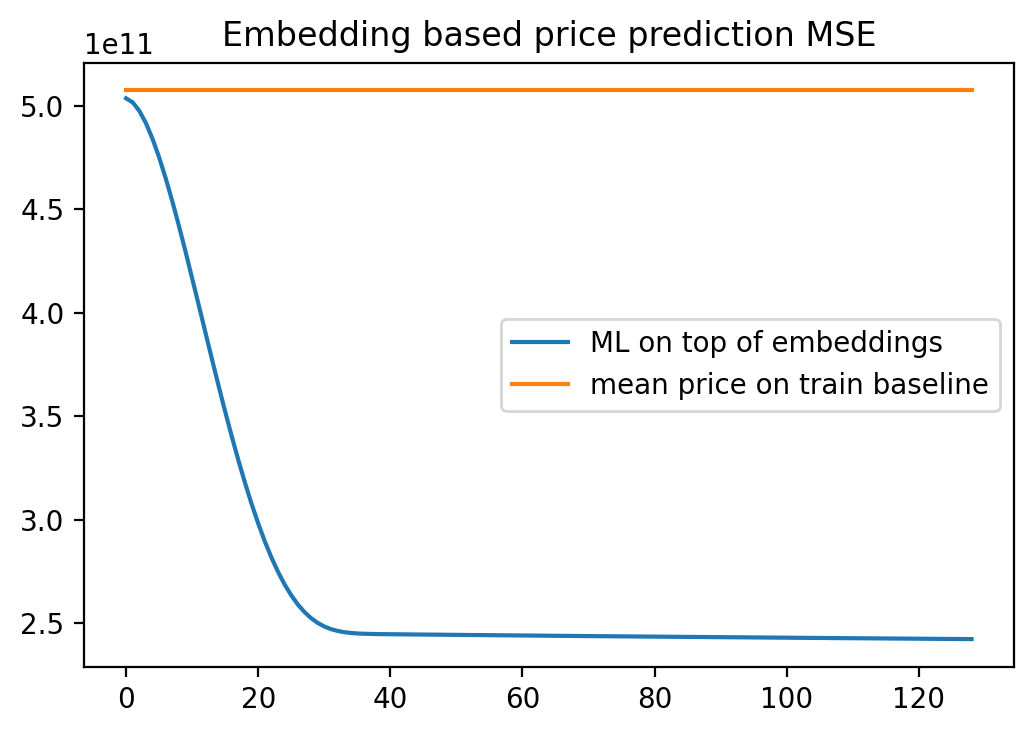

In [142]:
losses = [
    503674022291.20745850,501704075705.01696777,497640992328.36767578,491689293420.83068848,484115435814.26202393,475139487285.82159424,464989271005.49389648,453870586108.76470947,441998471723.55578613,429560988055.30993652,416731773200.56860352,403683142372.45678711,390566450207.24066162,377537998863.43365479,364719269546.03472900,352237977329.71191406,340186284935.46795654,328686494739.53985596,317793775162.57397461,307600259076.57482910,298155306032.84619141,289502441434.23937988,281689720181.24530029,274740246377.61618042,268650245768.50091553,263409201033.71508789,258978445029.42147827,255316125634.45443726,252370454200.85800171,250066054848.17572021,248329959986.51840210,247064261874.16677856,246178922974.64105225,245578071268.06732178,245188559585.65414429,244945126527.43740845,244795307235.93820190,244703368650.39334106,244642457142.89590454,244598432116.36370850,244562175110.05252075,244530521468.85189819,244501160306.97201538,244472833297.39157104,244441057120.41137695,244410286240.07009888,244380742072.02011108,244350036661.17404175,244318570808.37707520,244289144509.66809082,244259905373.34191895,244228051148.09893799,244197409164.16815186,244165540999.41357422,244135943386.19470215,244104655561.32455444,244076434759.86450195,244048081586.13998413,244014117104.37405396,243985794528.83905029,243954537585.03222656,243926111139.20288086,243898537245.97763062,243867011242.07656860,243841653712.75399780,243808795363.63848877,243779266281.45477295,243753826854.15332031,243724342241.59063721,243697380555.49649048,243670092995.80587769,243642367920.53488159,243611721849.24063110,243586360433.82101440,243556789710.96771240,243529386386.73971558,243506680064.06863403,243473968744.66571045,243449360297.11334229,243420996565.54357910,243395281594.29348755,243369590334.37582397,243342501456.82904053,243315288506.15707397,243290272897.32269287,243264629482.32836914,243236119544.37472534,243210067951.39962769,243185187286.64004517,243160139469.91073608,243133165459.94104004,243108911158.49624634,243083827002.93704224,243058066030.97567749,243033499546.34948730,243006606729.32144165,242984660849.60787964,242957210398.56259155,242933569012.36535645,242908880290.29266357,242886608557.14434814,242859658916.87139893,242836186407.89169312,242813115834.48522949,242787737838.23193359,242760405184.93823242,242739173338.39202881,242713753203.93826294,242690228001.46502686,242664812697.27725220,242642587628.61892700,242621547344.08563232,242592082309.32327271,242568642506.34481812,242547272048.61004639,242521213062.45605469,242497734647.18661499,242474776026.95288086,242450387877.50003052,242427504308.58099365,242403888520.97372437,242380756135.37020874,242354996099.94851685,242330131453.74349976,242308067794.87661743,242283281343.56616211,242259235182.61209106,242238979719.38116455,242216070568.12634277]
plt.plot(losses)
plt.plot(507700187082.0915 * np.ones_like(losses))
plt.legend(['ML on top of embeddings', 'mean price on train baseline'])
plt.title('Embedding based price prediction MSE')
plt.show()

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split


idxs = train['construction_status'] != ''
X_train, X_test, y_train, y_test = train_test_split(embeddings[idxs], pd.factorize(train[idxs]['construction_status'])[0], test_size=0.2, random_state=42)
clf = MLPClassifier(verbose=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

Iteration 1, loss = 0.77720374
Iteration 2, loss = 0.67085627
Iteration 3, loss = 0.62964056
Iteration 4, loss = 0.59809042
Iteration 5, loss = 0.57169361
Iteration 6, loss = 0.56266778
Iteration 7, loss = 0.55605215
Iteration 8, loss = 0.54505862
Iteration 9, loss = 0.52716736
Iteration 10, loss = 0.52783558
Iteration 11, loss = 0.51563002
Iteration 12, loss = 0.51358394
Iteration 13, loss = 0.50776362
Iteration 14, loss = 0.50485429
Iteration 15, loss = 0.50644791
Iteration 16, loss = 0.49853876
Iteration 17, loss = 0.49863817
Iteration 18, loss = 0.48747522
Iteration 19, loss = 0.48383862
Iteration 20, loss = 0.48403445
Iteration 21, loss = 0.49227563
Iteration 22, loss = 0.47606058
Iteration 23, loss = 0.49110549
Iteration 24, loss = 0.48561543
Iteration 25, loss = 0.47535134
Iteration 26, loss = 0.46868995
Iteration 27, loss = 0.47241898
Iteration 28, loss = 0.47403860
Iteration 29, loss = 0.46872984
Iteration 30, loss = 0.46662583
Iteration 31, loss = 0.46349556
Iteration 32, los

/home/ptr/Studies/hackathon/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.834180312441182

In [92]:
pd.factorize(train[idxs]['construction_status'])[1]

Index(['ready_to_use', 'to_completion', 'to_renovation', 'unfinished_close'], dtype='object')

/home/ptr/Studies/hackathon/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


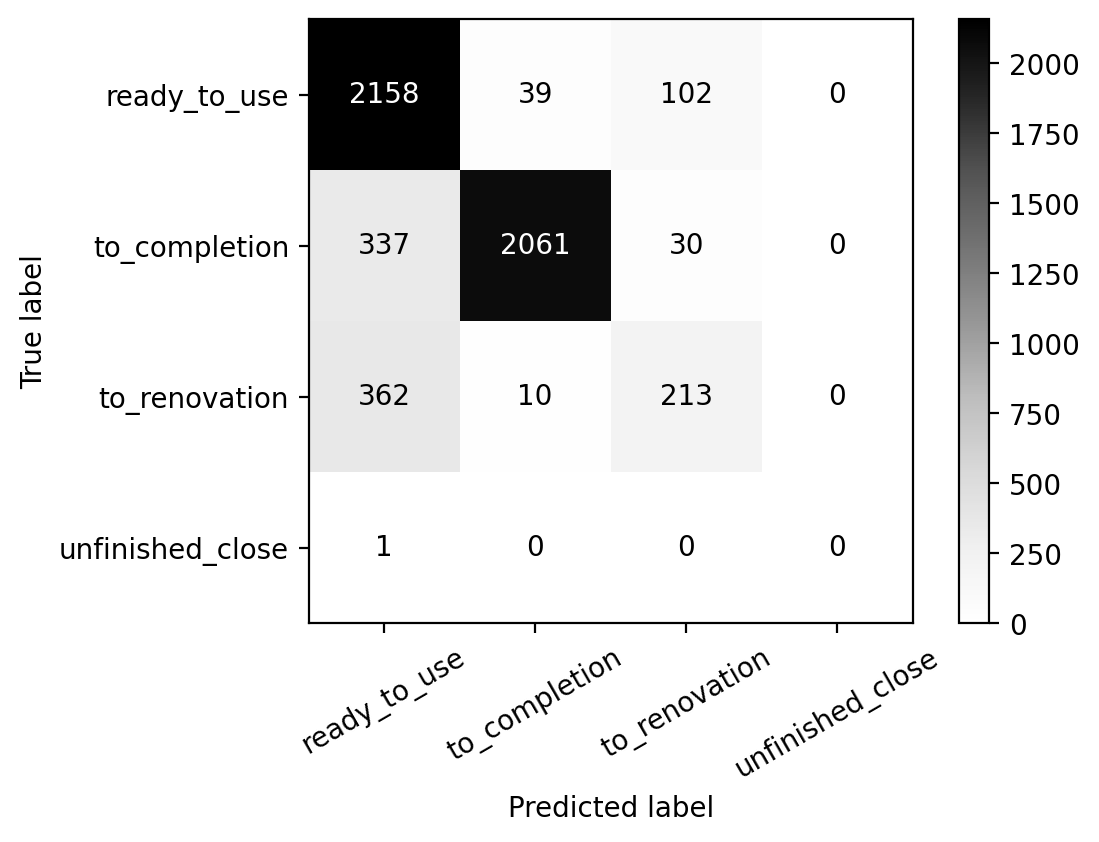

In [150]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels=list(pd.factorize(train[idxs]['construction_status'])[1]), xticks_rotation=30., cmap="Greys")

In [28]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [97]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

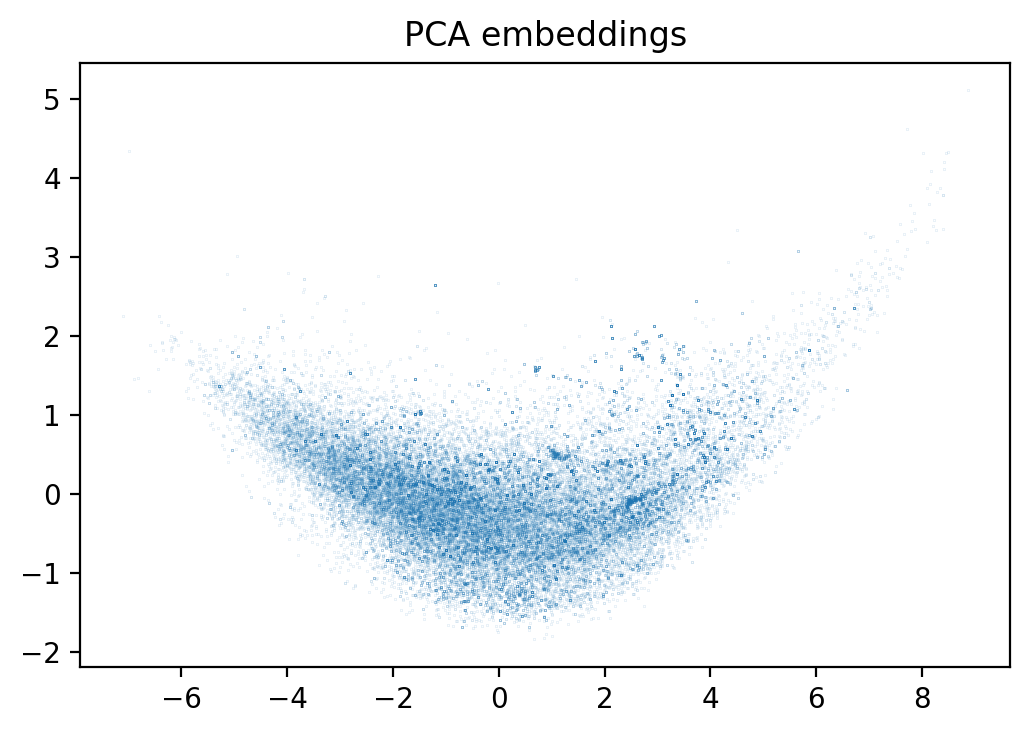

In [127]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], s=.001)
plt.title('PCA embeddings')
plt.show()

In [107]:
import umap
embeddings_umap = umap.UMAP(n_components=2, verbose=True).fit_transform(embeddings)

UMAP( verbose=True)
Sun Jun  5 10:02:11 2022 Construct fuzzy simplicial set
Sun Jun  5 10:02:11 2022 Finding Nearest Neighbors
Sun Jun  5 10:02:11 2022 Building RP forest with 16 trees
Sun Jun  5 10:02:13 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Jun  5 10:02:15 2022 Finished Nearest Neighbor Search
Sun Jun  5 10:02:15 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Jun  5 10:02:52 2022 Finished embedding


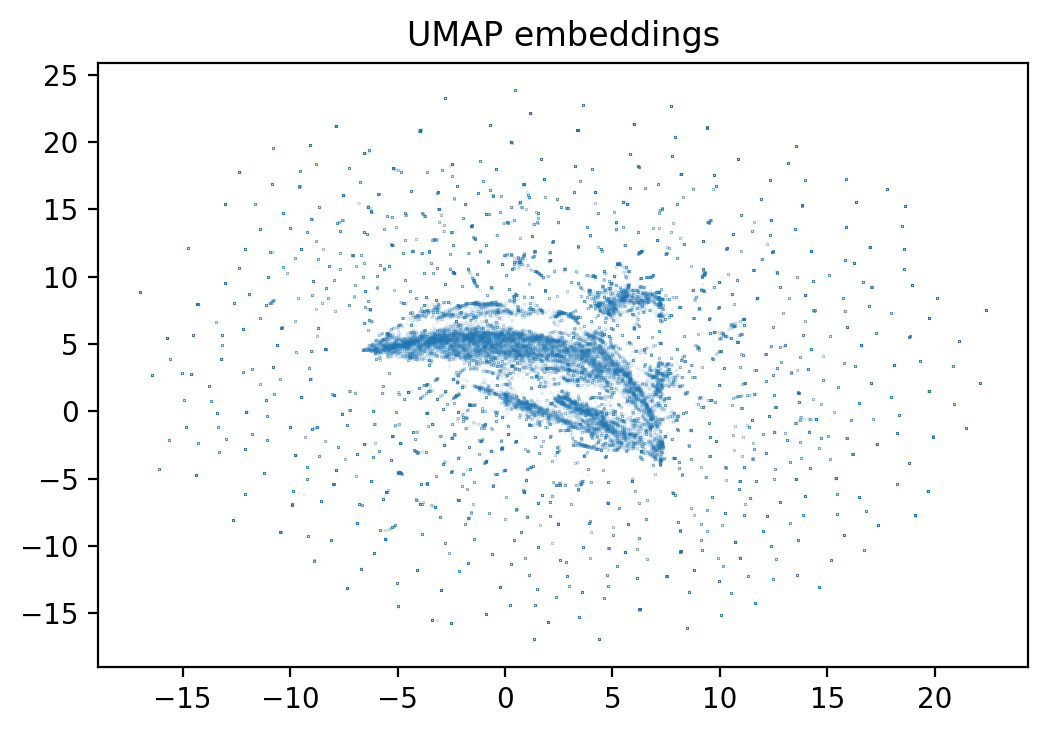

In [130]:
import matplotlib.pyplot as plt
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], s=0.001)
plt.title('UMAP embeddings')
plt.show()

In [42]:
import numpy as np

np.save('embeddings.npy', embeddings)